In [1]:
import pandas as pd
raw_data = pd.read_csv('/Users/teacher/repos/s21_ds_nlp/classes/week_7/data/headlines', error_bad_lines=False);
#raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

display(raw_data.head())

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [2]:
from sklearn.feature_extraction.text import CountVectorizer

small_count_vectorizer = CountVectorizer(stop_words='english', max_features=400)
small_text_sample = reindexed_data.sample(n=10000, random_state=0)#.as_matrix()

display(small_text_sample)
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)
display(small_document_term_matrix)


publish_date
20030224            spanish protest against prestige disaster
20030314    opposition to second regulated power interconn...
20030315         sydney roosters kick off season with victory
20030314                     dead woman found two years later
20030402           recovery underway for born again florentia
20030326              woodchip trucks safe industry officials
20030404                 russia slams ban on participation in
20030303              woods pulls out of dubai desert classic
20030405        raiders broncos undefeated knights deny storm
20030301                               joeys into fifa worlds
20030328     suspects in djindjic murder killed during arrest
20030309                        sa vic finish season in style
20030301        boulami suspended by iaaf pending arbitration
20030226               union airs tertiary education concerns
20030409           residents alerted to possible water crisis
20030306       developer asked to provide more informatio

<10000x400 sparse matrix of type '<class 'numpy.int64'>'
	with 19229 stored elements in Compressed Sparse Row format>

In [3]:
from sklearn.decomposition import TruncatedSVD

n_topics = 8

lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)
display(lsa_topic_matrix)

array([[ 4.98108688e-02,  7.54476552e-02, -6.10265553e-03, ...,
        -2.82988504e-03, -7.74313437e-03,  5.17741436e-03],
       [ 1.42231922e-02,  3.43498719e-03,  1.76389296e-02, ...,
         1.38485956e-02,  1.57549350e-02,  9.48093726e-03],
       [ 1.38671728e-02,  2.17205170e-02,  1.46374408e-02, ...,
         1.63051044e-02, -6.60360039e-03,  1.00127236e-02],
       ...,
       [ 7.28484888e-04,  3.36887657e-03,  1.31928744e-02, ...,
        -8.64439777e-05,  9.82267661e-04,  7.33466037e-03],
       [ 1.44721518e-01, -1.04244982e-01,  5.30128874e-02, ...,
         3.28755784e-02,  8.43975141e-01, -2.20853185e-01],
       [ 3.21392559e-03,  3.21339270e-03,  1.39790891e-02, ...,
         2.08540122e-02,  9.95913387e-03,  1.81768334e-02]])

In [4]:
from collections import Counter
# Define helper functions
def get_keys(topic_matrix):
    '''returns an integer list of predicted topic categories for a given topic matrix'''
    keys = []
    for i in range(topic_matrix.shape[0]):
        keys.append(topic_matrix[i].argmax())
    return keys

def keys_to_counts(keys):
    '''returns a tuple of topic categories and their accompanying magnitudes for a given list of keys'''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [5]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [6]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''returns a list of n_topic strings, where each string contains the n most common 
        words in a predicted category, in order'''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [7]:
import numpy as np
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i), top_n_words_lsa[i])

Topic 0:  iraq war pm howard bush says denies oil turkey troops
Topic 1:  war anti protest protesters students protests rally sydney greens march
Topic 2:  police death probe car missing clash coast search crash drug
Topic 3:  govt nsw qld claims vic drought wa health urged claim
Topic 4:  man court face charged murder hospital dies charges trial charge
Topic 5:  new win sars takes season hopes work set hits resolution
Topic 6:  says iraqi baghdad killed troops korea forces crash dead saddam
Topic 7:  council water plan cup world rain boost security funds australia


Text(0.5, 1.0, 'LSA Topic Category Counts')

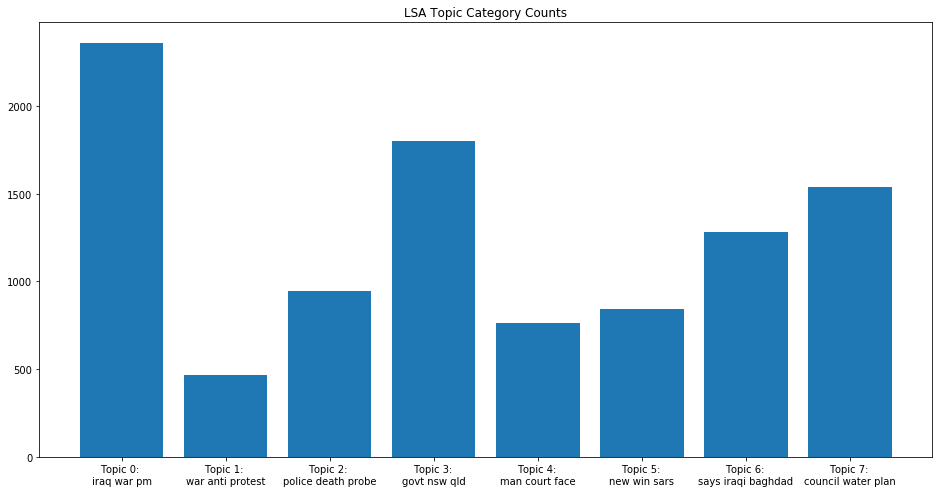

In [8]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts)
ax.set_xticks(lsa_categories)
ax.set_xticklabels(labels)
ax.set_title('LSA Topic Category Counts')